In [24]:
import torch
import torch_harmonics as th
import numpy as np
import os 
import h5py
import glob
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
import matplotlib.colors as colors

from varsStormer import varsStormer
from stormer_utils_pangu import StormerWrapperPangu

In [2]:
def read_era5(data,vars_stormer):
    data_np = np.zeros((len(vars_stormer),128,256))
    for i,var in enumerate(vars_stormer):
        data_np[i] = data['input/{}'.format(var)][:]
    return data_np

def norm_era5(data_np,vars_stormer,stormer_wrapper):
    data_torch = torch.from_numpy(data_np)
    data_torch_norm = stormer_wrapper.inp_transform(data_torch)
    data_np_norm = data_torch_norm.numpy()
    return data_np_norm

In [3]:
forecast_dir = '/eagle/MDClimSim/mjp5595/data/stormer/stormer_forecasts_2017_norm/'
era5_dir = '/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/train/'

vars_stormer = varsStormer().vars_stormer

stormer_wrapper = StormerWrapperPangu(
    root_dir='/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/',
    variables=vars_stormer,
    net=None,
    base_lead_time=[6],
    ckpt=None,
    device=None,
)

checkpoint model loaded


In [10]:
init_forecasts_norm = h5py.File('/eagle/MDClimSim/mjp5595/data/stormer/stormer_init_12hr_forecast/norm_0002.h5','r')
init_forecasts_raw = h5py.File('/eagle/MDClimSim/mjp5595/data/stormer/stormer_init_12hr_forecast/raw_0002.h5','r')
analysis_forecasts_norm = h5py.File('/eagle/MDClimSim/mjp5595/data/stormer/var3d_troyB_12init_gpu0/data/forecasts_0_1201012014.h5','r')
analysis_forecasts_raw = h5py.File('/eagle/MDClimSim/mjp5595/data/stormer/var3d_troyB_12init_gpu0/data/raw_forecasts_0_1201012014.h5','r')
era5_dir = '/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/train/'

gt.shape : (69, 128, 256)
Plotting hr forecast : 0
gt.shape : (69, 128, 256)
Plotting hr forecast : 24
gt.shape : (69, 128, 256)
Plotting hr forecast : 96


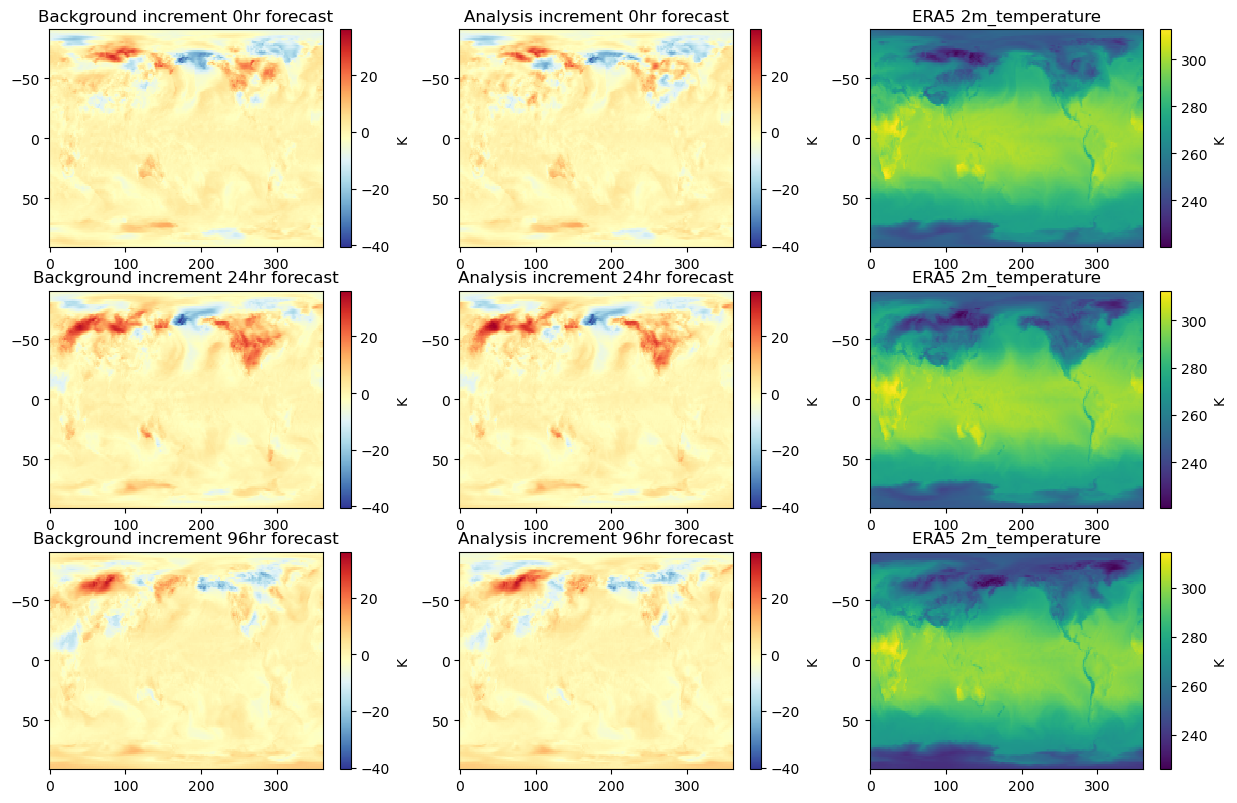

In [38]:
# init_forecasts_raw['0'].shape # (69,128,256)
# max(init_forecasts_raw.keys()) # 96

lon = np.linspace(0,360,256)
lat = np.linspace(90,-90,128)

fig = plt.figure(figsize=(15,13))
axs = []

hrs_to_plot = [0,24,96]

inc_min = 0
inc_max = 0
for i,hr in enumerate(hrs_to_plot):
    gt = read_era5(h5py.File(os.path.join(era5_dir,'2017_{:0>4d}.h5'.format(2+int(hr))),'r'),vars_stormer)
    init_fc = init_forecasts_raw[str(hr)][:]
    ana_fc = analysis_forecasts_raw[str(hr)][:]
    init_increment = init_fc - gt
    ana_increment = ana_fc - gt

    inc_min = min(inc_min,np.min(init_increment[0]),np.min(ana_increment[0]))
    inc_max = max(inc_max,np.max(init_increment[0]),np.max(ana_increment[0]))

perts = []
for i,hr in enumerate(hrs_to_plot):
    gt = read_era5(h5py.File(os.path.join(era5_dir,'2017_{:0>4d}.h5'.format(2+int(hr))),'r'),vars_stormer)
    print('gt.shape :',gt.shape)
    init_fc = init_forecasts_raw[str(hr)][:]
    ana_fc = analysis_forecasts_raw[str(hr)][:]
    
    print('Plotting hr forecast :',hr)
    init_increment = init_fc - gt
    ana_increment = ana_fc - gt


    str_int = '43' + str((i*3)+1)
    axs.append(fig.add_subplot(int(str_int)))
    axs[-1].invert_yaxis()
    #perts.append(axs[-1].pcolormesh(lon, lat, init_increment[0], cmap=cm.coolwarm, norm=colors.SymLogNorm(linthresh=1,vmin=inc_min,vmax=inc_max)))
    perts.append(axs[-1].pcolormesh(lon, lat, init_increment[0], cmap='RdYlBu_r', vmin=inc_min,vmax=inc_max))
    plt.colorbar(perts[-1], ax = axs[-1], label='K')
    axs[-1].set_title('Background increment {}hr forecast'.format(hr))

    str_int = '43' + str((i*3)+2)
    axs.append(fig.add_subplot(int(str_int)))
    axs[-1].invert_yaxis()
    #perts.append(axs[-1].pcolormesh(lon, lat, ana_increment[0], cmap=cm.coolwarm, norm=colors.SymLogNorm(linthresh=1,vmin=inc_min,vmax=inc_max)))
    perts.append(axs[-1].pcolormesh(lon, lat, ana_increment[0], cmap='RdYlBu_r', vmin=inc_min,vmax=inc_max))
    plt.colorbar(perts[-1], ax = axs[-1], label='K')
    axs[-1].set_title('Analysis increment {}hr forecast'.format(hr))

    str_int = '43' + str((i*3)+3)
    axs.append(fig.add_subplot(int(str_int)))
    axs[-1].invert_yaxis()
    perts.append(axs[-1].pcolormesh(lon, lat, gt[0], cmap='viridis'))
    plt.colorbar(perts[-1], ax = axs[-1], label='K')
    axs[-1].set_title('ERA5 2m_temperature')
plt.savefig('/eagle/MDClimSim/mjp5595/ml4dvar/plots/stormer_val_bg_vs_init_fc.png')

In [27]:
forecasts_raw = h5py.File(os.path.join(forecast_dir,'raw_0000.h5'),'r')
forecasts_norm = h5py.File(os.path.join(forecast_dir,'norm_0000.h5'),'r')
gt_0 = h5py.File(os.path.join(era5_dir,'2017_0000.h5'),'r')
gt_6 = h5py.File(os.path.join(era5_dir,'2017_0001.h5'),'r')

In [28]:
# This Validates the forecasts in /stormer/stormer_forecasts_2017_norm/ vs ground truth

diff_init = forecasts_raw['0'][:] - read_era5(gt_0,vars_stormer)
print('diff_init :',np.max(diff_init))
diff_pred_vs_gt = forecasts_raw['6'][:] - read_era5(gt_6,vars_stormer)
print('diff_pred_vs_gt :',np.max(diff_pred_vs_gt))
diff_pred_vs_init = forecasts_raw['6'][:] - forecasts_raw['0'][:]
print('diff_pred_vs_init :',np.max(diff_pred_vs_init))

diff_init : 0.0
diff_pred_vs_gt : 305.671875
diff_pred_vs_init : 2019.2266
